In [2]:
!pip install tensorflow pandas scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 117.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 116.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.9 MB/s eta 0:00:00


Using device: /CPU:0
Training starts...
E[100/4000], L1:5.623e+04, L2:3.003e+03, Tot:5.923e+04, LR:5.00e-04
E[200/4000], L1:1.644e+04, L2:4.600e+02, Tot:1.690e+04, LR:5.00e-04
E[300/4000], L1:1.050e+04, L2:1.843e+02, Tot:1.069e+04, LR:5.00e-04
E[400/4000], L1:5.639e+03, L2:1.268e+02, Tot:5.766e+03, LR:5.00e-04
E[500/4000], L1:2.746e+03, L2:1.902e+02, Tot:2.936e+03, LR:5.00e-04
E[600/4000], L1:1.802e+03, L2:3.113e+02, Tot:2.114e+03, LR:5.00e-04
E[700/4000], L1:1.636e+03, L2:3.204e+02, Tot:1.956e+03, LR:5.00e-04
E[800/4000], L1:1.468e+03, L2:3.354e+02, Tot:1.803e+03, LR:5.00e-04
E[900/4000], L1:1.291e+03, L2:3.586e+02, Tot:1.650e+03, LR:5.00e-04
E[1000/4000], L1:1.136e+03, L2:3.783e+02, Tot:1.514e+03, LR:4.80e-04
E[1100/4000], L1:9.650e+02, L2:4.050e+02, Tot:1.370e+03, LR:4.80e-04
E[1200/4000], L1:7.965e+02, L2:4.388e+02, Tot:1.235e+03, LR:4.80e-04
E[1300/4000], L1:6.318e+02, L2:4.815e+02, Tot:1.113e+03, LR:4.80e-04
E[1400/4000], L1:4.996e+02, L2:5.213e+02, Tot:1.021e+03, LR:4.80e-04
E[1

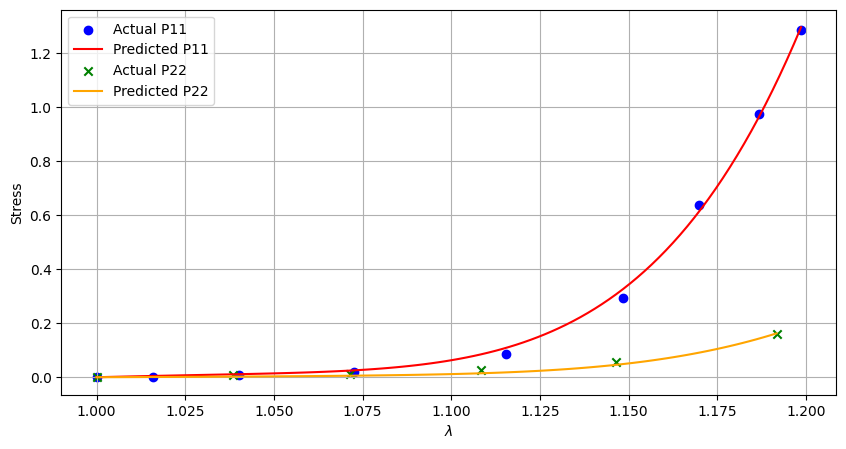


Calculating contributions for uniaxial...
  - Calculated contribution for term: Pow(I1)
  - Calculated contribution for term: Pow(I2)
  - Calculated contribution for term: Exp(I1)


  - Calculated contribution for term: Exp(I2)
  - Calculated contribution for term: Pow(I4)
  - Calculated contribution for term: Pow(I6)
  - Calculated contribution for term: Exp(I4)
  - Calculated contribution for term: Exp(I6)

Calculating contributions for biaxial...
  - Calculated contribution for term: Pow(I1)
  - Calculated contribution for term: Pow(I2)
  - Calculated contribution for term: Exp(I1)


  - Calculated contribution for term: Exp(I2)


  - Calculated contribution for term: Pow(I4)
  - Calculated contribution for term: Pow(I6)
  - Calculated contribution for term: Exp(I4)
  - Calculated contribution for term: Exp(I6)

Successfully saved stress contributions to 'P_contributions_exp_power.csv'


In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
from scipy.io import savemat

tf.keras.backend.set_floatx('float64')
DEVICE = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(f"Using device: {DEVICE}")

ARG_CLIP_MIN = tf.constant(-10.0, dtype=tf.float64)
ARG_CLIP_MAX = tf.constant(10.0, dtype=tf.float64)

# --- Simplified Model for Exponential Power Terms Only ---
class StrainEnergy_ExpPower(tf.keras.Model):
    def __init__(self):
        super().__init__(name="StrainEnergy_ExpPower")
        # Power Law terms (I1, I2)
        self.raw_log_k1=self.add_weight(name="raw_log_k1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k2=self.add_weight(name="raw_log_k2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i1=self.add_weight(name="raw_log_i1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i2=self.add_weight(name="raw_log_i2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_a1=self.add_weight(name="raw_log_a1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a2=self.add_weight(name="raw_log_a2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)

        # Exponential with i terms (I1, I2)
        self.raw_log_k3=self.add_weight(name="raw_log_k3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k4=self.add_weight(name="raw_log_k4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i3=self.add_weight(name="raw_log_i3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i4=self.add_weight(name="raw_log_i4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_a3=self.add_weight(name="raw_log_a3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a4=self.add_weight(name="raw_log_a4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a3_prime=self.add_weight(name="raw_log_a3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a4_prime=self.add_weight(name="raw_log_a4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)

        # Power Law terms for I4, I6 (Identity Scaled)
        self.raw_log_k9=self.add_weight(name="raw_log_k9",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k10=self.add_weight(name="raw_log_k10",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_b1=self.add_weight(name="raw_log_b1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.01)),trainable=True)
        self.raw_log_b2=self.add_weight(name="raw_log_b2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.01)),trainable=True)

        # Exponential terms for I4, I6
        self.raw_log_k11=self.add_weight(name="raw_log_k11",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k12=self.add_weight(name="raw_log_k12",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_b3=self.add_weight(name="raw_log_b3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b4=self.add_weight(name="raw_log_b4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b3_prime=self.add_weight(name="raw_log_b3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b4_prime=self.add_weight(name="raw_log_b4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)

        self.three=tf.constant(3.0,dtype=tf.float64); self.one=tf.constant(1.0,dtype=tf.float64); self.pow_base_epsilon=tf.constant(1e-8,dtype=tf.float64)

    def _term_power_law(self, I, k, i, c, ref_val): return c * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i)
    def _term_exponential(self, I, k, i, ic, oc, ref_val): return oc * (tf.exp(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_identity_scaled(self, I, k, c, ref_val): return c * (tf.pow(I, k) - tf.pow(ref_val, k))
    def _term_exponential_no_i(self, I, k, ic, oc, ref_val): return oc * (tf.exp(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)

    def call(self, I1, I2, I4, I6):
        k1=1.0+tf.exp(self.raw_log_k1); k2=1.5+tf.exp(self.raw_log_k2); k3=1.0+tf.exp(self.raw_log_k3); k4=1.5+tf.exp(self.raw_log_k4)
        i1=1.0+tf.exp(self.raw_log_i1); i2=1.0+tf.exp(self.raw_log_i2); i3=1.0+tf.exp(self.raw_log_i3); i4=1.0+tf.exp(self.raw_log_i4)
        a1=tf.exp(self.raw_log_a1); a2=tf.exp(self.raw_log_a2); a3=tf.exp(self.raw_log_a3); a4=tf.exp(self.raw_log_a4)
        a3_prime=tf.exp(self.raw_log_a3_prime); a4_prime=tf.exp(self.raw_log_a4_prime)
        k9=1.0+tf.exp(self.raw_log_k9); k10=1.5+tf.exp(self.raw_log_k10); k11=1.0+tf.exp(self.raw_log_k11); k12=1.5+tf.exp(self.raw_log_k12)
        b1=tf.exp(self.raw_log_b1); b2=tf.exp(self.raw_log_b2); b3=tf.exp(self.raw_log_b3); b4=tf.exp(self.raw_log_b4)
        b3_prime=tf.exp(self.raw_log_b3_prime); b4_prime=tf.exp(self.raw_log_b4_prime)

        W = tf.zeros_like(I1, dtype=tf.float64)
        W += self._term_power_law(I1, k1, i1, a1, self.three)
        W += self._term_power_law(I2, k2, i2, a2, self.three)
        W += self._term_exponential(I1, k3, i3, a3_prime, a3, self.three)
        W += self._term_exponential(I2, k4, i4, a4_prime, a4, self.three)
        W += self._term_identity_scaled(I4, k9, b1, self.one)
        W += self._term_identity_scaled(I6, k10, b2, self.one)
        W += self._term_exponential_no_i(I4, k11, b3_prime, b3, self.one)
        W += self._term_exponential_no_i(I6, k12, b4_prime, b4, self.one)
        return W

# ... (All the original stress calculation functions remain the same) ...
# ... (get_invariants_tf, get_W_and_gradients_tf, calculate_P11_task1_tf, etc.) ...
@tf.function
def get_invariants_tf(lambda1,lambda2,lambda3):
    min_lambda_val=tf.constant(1e-4,dtype=tf.float64); lambda1=tf.maximum(lambda1,min_lambda_val); lambda2=tf.maximum(lambda2,min_lambda_val); lambda3=tf.maximum(lambda3,min_lambda_val); l1s=tf.pow(lambda1,2.0); l2s=tf.pow(lambda2,2.0); l3s=tf.pow(lambda3,2.0)
    I1=l1s+l2s+l3s; I2=tf.pow(lambda1*lambda2,2.0)+tf.pow(lambda2*lambda3,2.0)+tf.pow(lambda3*lambda1,2.0); I4=l1s; I6=tf.pow(lambda1,-2.0)
    return I1,I2,I4,I6
@tf.function
def get_W_and_gradients_tf(l1t,l2t,l3t,model, W_func):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch([l1t, l2t, l3t]); I1, I2, I4, I6 = get_invariants_tf(l1t, l2t, l3t); W_val = W_func(I1, I2, I4, I6)
    grads = tape.gradient(W_val, [l1t, l2t, l3t]); dWdl1 = grads[0] if grads[0] is not None else tf.zeros_like(l1t); dWdl2 = grads[1] if grads[1] is not None else tf.zeros_like(l2t); dWdl3 = grads[2] if grads[2] is not None else tf.zeros_like(l3t)
    return W_val, dWdl1, dWdl2, dWdl3
@tf.function
def _calculate_raw_P11_task1_tf(l1vst, model, W_func):
    l1t = tf.maximum(l1vst, tf.constant(1e-4, dtype=tf.float64))
    l2t = tf.pow(l1t, -0.5)
    l3t = tf.pow(l1t, -0.5)
    _, dWdl1, _, dWdl3 = get_W_and_gradients_tf(l1t, l2t, l3t, model, W_func)
    Ph = l3t * dWdl3
    safe_l1t = tf.maximum(l1t, tf.constant(1e-6, dtype=tf.float64))
    return (dWdl1 - Ph / safe_l1t) / 7.5
@tf.function
def calculate_P11_task1_tf(l1vst, model, W_func):
    p11_raw = _calculate_raw_P11_task1_tf(l1vst, model, W_func)
    p11_offset = _calculate_raw_P11_task1_tf(tf.constant([1.0], dtype=tf.float64), model, W_func)
    return p11_raw - p11_offset

@tf.function
def sigma11_for_root_tf(lambda1_trial_t, lambda2_fixed_t_tensor, model, W_func):
    lambda1_trial_t_stable = tf.maximum(lambda1_trial_t, tf.constant(1e-4, dtype=tf.float64)); lambda2_fixed_t_stable = tf.maximum(lambda2_fixed_t_tensor, tf.constant(1e-4, dtype=tf.float64))
    safe_denom_prod = tf.maximum(lambda1_trial_t_stable * lambda2_fixed_t_stable, tf.constant(1e-6, dtype=tf.float64)); lambda3_trial_t = (1.0 / safe_denom_prod)
    _, dW_dlambda1, _, dW_dlambda3 = get_W_and_gradients_tf(lambda1_trial_t_stable, lambda2_fixed_t_stable, lambda3_trial_t, model, W_func); P_hydro = lambda3_trial_t * dW_dlambda3
    safe_lambda1_trial_t_stable = tf.maximum(lambda1_trial_t_stable, tf.constant(1e-6, dtype=tf.float64)); return (dW_dlambda1 - P_hydro / safe_lambda1_trial_t_stable)

@tf.function
def find_lambda1_newton_tf(lambda2_val_scalar_tensor, model, W_func, initial_lambda1_guess=1.0, iterations=tf.constant(10, dtype=tf.int32), tol=1e-7):
    min_lambda_val_newton=tf.constant(0.2,dtype=tf.float64); max_lambda_val_newton=tf.constant(3.0,dtype=tf.float64); max_step_lambda=tf.constant(0.1,dtype=tf.float64)
    loop_vars = [tf.constant(0, dtype=tf.int32), initial_lambda1_guess, tf.constant(False, dtype=tf.bool)]
    def cond(i, _, converged): return tf.logical_and(i < iterations, tf.logical_not(converged))
    def body(i, current_lambda, _):
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(current_lambda); sigma11 = sigma11_for_root_tf(current_lambda, lambda2_val_scalar_tensor, model, W_func)
        grad = tape.gradient(sigma11, current_lambda); newly_converged = tf.abs(sigma11) < tol
        problem = grad is None or tf.math.is_nan(grad) or tf.math.is_inf(grad)
        def update_lambda():
            delta = sigma11 / (grad + tf.constant(1e-8, dtype=tf.float64) * tf.sign(grad)); problem_delta = tf.math.is_nan(delta) or tf.math.is_inf(delta)
            safe_delta = tf.cond(problem_delta, lambda: tf.constant(0.0, dtype=tf.float64), lambda: delta); clipped_delta = tf.clip_by_value(safe_delta, -max_step_lambda, max_step_lambda)
            return tf.clip_by_value(current_lambda - clipped_delta, min_lambda_val_newton, max_lambda_val_newton)
        next_lambda = tf.cond(problem, lambda: current_lambda, update_lambda); return [i + 1, next_lambda, tf.logical_or(newly_converged, problem)]
    _, final_lambda, _ = tf.while_loop(cond, body, loop_vars); return final_lambda

@tf.function
def _calculate_raw_P22_task2_tf(lambda2_val_scalar_tensor, model, W_func):
    lambda2_stable = tf.maximum(lambda2_val_scalar_tensor, tf.constant(1e-4, dtype=tf.float64))
    initial_lambda1_guess = 1.0 / tf.sqrt(lambda2_stable)
    lambda1_root_t = find_lambda1_newton_tf(lambda2_stable, model, W_func, initial_lambda1_guess)
    lambda1_root_t_stable = tf.maximum(lambda1_root_t, tf.constant(1e-4, dtype=tf.float64))
    safe_denom = tf.maximum(lambda1_root_t_stable * lambda2_stable, tf.constant(1e-6, dtype=tf.float64))
    lambda3_calc_t = (1.0 / safe_denom)
    _, _, dWdl2, dWdl3 = get_W_and_gradients_tf(lambda1_root_t_stable, lambda2_stable, lambda3_calc_t, model, W_func)
    Ph = lambda3_calc_t * dWdl3
    safe_lambda2_calc_t = tf.maximum(lambda2_stable, tf.constant(1e-6, dtype=tf.float64))
    return (dWdl2 - Ph / safe_lambda2_calc_t) / 50
@tf.function
def calculate_P22_task2_tf_batch(lambda2_batch, model, W_func):
    p22_raw_batch = tf.scan(lambda _, l2: _calculate_raw_P22_task2_tf(l2, model, W_func), lambda2_batch, initializer=tf.constant(0.0, dtype=tf.float64))
    p22_offset = _calculate_raw_P22_task2_tf(tf.constant(1.0, dtype=tf.float64), model, W_func)
    return p22_raw_batch - p22_offset

# ... (Data Loading and Normalization remain the same) ...
exp_data_raw_uniaxial_cnf=np.array([[1.1986196319018403,1.285990338164251],[1.18680981595092,0.9768115942028984],[1.1699386503067484,0.638647342995169],[1.1483128834355827,0.29275362318840586],[1.1153374233128834,0.08502415458937207],[1.0725460122699388,0.018357487922705418],[1.040184049079755,0.00869565217391316],[1.0157975460122703,0.0019323671497585848],[1.0,0.0]])
lambda1_data_task1_np=exp_data_raw_uniaxial_cnf[:,0]; P11_data_task1_np=exp_data_raw_uniaxial_cnf[:,1]
csv_content_cnf="lambda,stress\n1.1917177914110426,0.16038647342995177\n1.1464723926380367,0.056038647342995296\n1.108435582822086,0.028019323671497676\n1.071472392638037,0.013526570048309317\n1.038343558282209,0.006763285024154686\n1.0,0.0\n"
df_task2=pd.read_csv(StringIO(csv_content_cnf)); lambda2_data_task2_np=df_task2['lambda'].values; P22_data_task2_np=df_task2['stress'].values
stress_scale = max(np.max(P11_data_task1_np), np.max(P22_data_task2_np))
P11_data_task1_norm_np = P11_data_task1_np / stress_scale
P22_data_task2_norm_np = P22_data_task2_np / stress_scale
stress_scale_tf = tf.constant(stress_scale, dtype=tf.float64)
lambda1_data_task1_tf=tf.constant(lambda1_data_task1_np,dtype=tf.float64)
P11_data_task1_norm_tf=tf.constant(P11_data_task1_norm_np,dtype=tf.float64)
lambda2_data_task2_tf=tf.constant(lambda2_data_task2_np,dtype=tf.float64)
P22_data_task2_norm_tf=tf.constant(P22_data_task2_norm_np,dtype=tf.float64)

# --- Model, Optimizer, and Training Setup remain the same ---
model_tf_layered = StrainEnergy_ExpPower()
L2_REG_STRENGTH = tf.constant(1e-12, dtype=tf.float64)
POSITIVITY_PENALTY_STRENGTH = tf.constant(5e4, dtype=tf.float64)
initial_learning_rate = 5e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=1000, decay_rate=0.96, staircase=True)
optimizer_tf = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

@tf.function
def train_step_final(l1_batch, p11_batch_norm, l2_batch, p22_batch_norm, model, scale_factor, l2_reg, pos_penalty_strength):
    with tf.GradientTape() as tape:
        p11_pred = calculate_P11_task1_tf(l1_batch, model, model.call)
        p22_pred = calculate_P22_task2_tf_batch(l2_batch, model, model.call)

        p11_pred_norm = p11_pred / scale_factor
        p22_pred_norm = p22_pred / scale_factor

        loss1_weight = 2500000.0
        loss2_weight = 10000000.0
        loss1 = tf.reduce_mean(tf.square(p11_batch_norm - p11_pred_norm)) * loss1_weight
        loss2 = tf.reduce_mean(tf.square(p22_batch_norm - p22_pred_norm)) * loss2_weight

        positivity_loss_1 = tf.reduce_mean(tf.nn.relu(-p11_pred))
        positivity_loss_2 = tf.reduce_mean(tf.nn.relu(-p22_pred))
        l2_loss = tf.add_n([tf.nn.l2_loss(v) for v in model.trainable_variables])
        total_loss = (loss1 + loss2 +
                      l2_reg * l2_loss +
                      pos_penalty_strength * (positivity_loss_1 + positivity_loss_2))
    t_vars = model.trainable_variables
    grads = tape.gradient(total_loss, t_vars)
    optimizer_tf.apply_gradients(zip([tf.clip_by_norm(g, 1.0) if g is not None else tf.zeros_like(v) for g, v in zip(grads, t_vars)], t_vars))
    return loss1, loss2, total_loss

# --- Training Loop remains the same ---
epochs=4000
dI1=tf.constant([3.0],dtype=tf.float64); dI2=tf.constant([3.0],dtype=tf.float64); dI4=tf.constant([1.0],dtype=tf.float64); dI6=tf.constant([1.e-6],dtype=tf.float64)
_=model_tf_layered(dI1,dI2,dI4,dI6)
print("Training starts...");
for e in range(epochs):
    l1,l2,tl=train_step_final(lambda1_data_task1_tf, P11_data_task1_norm_tf, lambda2_data_task2_tf, P22_data_task2_norm_tf,
                              model_tf_layered, stress_scale_tf, L2_REG_STRENGTH, POSITIVITY_PENALTY_STRENGTH)
    if (e+1)%100==0:
        current_lr = lr_schedule(optimizer_tf.iterations).numpy()
        print(f"E[{e+1}/{epochs}], L1:{l1.numpy():.3e}, L2:{l2.numpy():.3e}, Tot:{tl.numpy():.3e}, LR:{current_lr:.2e}")

# ... (Standard plotting code remains the same) ...
# The data for plotting is generated here
l1_plot = np.linspace(lambda1_data_task1_np.min(), lambda1_data_task1_np.max(), 100)
p11_plot = calculate_P11_task1_tf(tf.constant(l1_plot, dtype=tf.float64), model_tf_layered, model_tf_layered.call).numpy()
l2_plot = np.linspace(lambda2_data_task2_np.min(), lambda2_data_task2_np.max(), 100)
p22_plot = calculate_P22_task2_tf_batch(tf.constant(l2_plot, dtype=tf.float64), model_tf_layered, model_tf_layered.call).numpy()

# Plotting the final results
plt.figure(figsize=(10, 5))
plt.scatter(lambda1_data_task1_np, P11_data_task1_np, c='b', label='Actual P11')
plt.plot(l1_plot, p11_plot, c='r', label='Predicted P11')
plt.scatter(lambda2_data_task2_np, P22_data_task2_np, c='g', marker='x', label='Actual P22')
plt.plot(l2_plot, p22_plot, c='orange', label='Predicted P22')
plt.legend(); plt.grid(True); plt.xlabel(r"$\lambda$"); plt.ylabel("Stress"); plt.show()


# ==============================================================================
# ===== NEW SECTION: CALCULATE AND SAVE STRESS CONTRIBUTIONS ===================
# ==============================================================================

def get_model_terms_exp_power(model):
    """Returns a dictionary of individual W term functions for the Exp-Power model."""
    k1=1.0+tf.exp(model.raw_log_k1); k2=1.5+tf.exp(model.raw_log_k2); k3=1.0+tf.exp(model.raw_log_k3); k4=1.5+tf.exp(model.raw_log_k4)
    i1=1.0+tf.exp(model.raw_log_i1); i2=1.0+tf.exp(model.raw_log_i2); i3=1.0+tf.exp(model.raw_log_i3); i4=1.0+tf.exp(model.raw_log_i4)
    a1=tf.exp(model.raw_log_a1); a2=tf.exp(model.raw_log_a2); a3=tf.exp(model.raw_log_a3); a4=tf.exp(model.raw_log_a4)
    a3_prime=tf.exp(model.raw_log_a3_prime); a4_prime=tf.exp(model.raw_log_a4_prime)
    k9=1.0+tf.exp(model.raw_log_k9); k10=1.5+tf.exp(model.raw_log_k10); k11=1.0+tf.exp(model.raw_log_k11); k12=1.5+tf.exp(model.raw_log_k12)
    b1=tf.exp(model.raw_log_b1); b2=tf.exp(model.raw_log_b2); b3=tf.exp(model.raw_log_b3); b4=tf.exp(model.raw_log_b4)
    b3_prime=tf.exp(model.raw_log_b3_prime); b4_prime=tf.exp(model.raw_log_b4_prime)

    terms = {
        "Pow(I1)":   lambda I1, I2, I4, I6: model._term_power_law(I1, k1, i1, a1, model.three),
        "Pow(I2)":   lambda I1, I2, I4, I6: model._term_power_law(I2, k2, i2, a2, model.three),
        "Exp(I1)":   lambda I1, I2, I4, I6: model._term_exponential(I1, k3, i3, a3_prime, a3, model.three),
        "Exp(I2)":   lambda I1, I2, I4, I6: model._term_exponential(I2, k4, i4, a4_prime, a4, model.three),
        "Pow(I4)":   lambda I1, I2, I4, I6: model._term_identity_scaled(I4, k9, b1, model.one),
        "Pow(I6)":   lambda I1, I2, I4, I6: model._term_identity_scaled(I6, k10, b2, model.one),
        "Exp(I4)":   lambda I1, I2, I4, I6: model._term_exponential_no_i(I4, k11, b3_prime, b3, model.one),
        "Exp(I6)":   lambda I1, I2, I4, I6: model._term_exponential_no_i(I6, k12, b4_prime, b4, model.one),
    }
    return terms

def calculate_stress_contributions(lambda_values, model, task_type):
    """Calculates the stress contribution of each term in the model."""
    terms = get_model_terms_exp_power(model)
    contributions = {}

    print(f"\nCalculating contributions for {task_type}...")

    for name, W_func in terms.items():
        if task_type == 'uniaxial':
            stress_contribution = calculate_P11_task1_tf(lambda_values, model, W_func)
        elif task_type == 'biaxial':
            stress_contribution = calculate_P22_task2_tf_batch(lambda_values, model, W_func)
        else:
            raise ValueError("task_type must be 'uniaxial' or 'biaxial'")

        contributions[name] = stress_contribution.numpy()
        print(f"  - Calculated contribution for term: {name}")

    return contributions

# Define smooth lambda ranges for plotting
lambda1_plot_tf = tf.constant(np.linspace(1.0, 1.2, 100), dtype=tf.float64)
lambda2_plot_tf = tf.constant(np.linspace(1.0, 1.2, 100), dtype=tf.float64)

# Calculate contributions for both tasks
p11_contributions = calculate_stress_contributions(lambda1_plot_tf, model_tf_layered, 'uniaxial')
p22_contributions = calculate_stress_contributions(lambda2_plot_tf, model_tf_layered, 'biaxial')

# Create a single DataFrame to hold all the data
df_contrib = pd.DataFrame()
df_contrib['lambda1'] = lambda1_plot_tf.numpy()
for name, values in p11_contributions.items():
    df_contrib[f'P11_{name}'] = values

df_contrib['lambda2'] = lambda2_plot_tf.numpy()
for name, values in p22_contributions.items():
    df_contrib[f'P22_{name}'] = values

# Save the DataFrame to a CSV file
output_filename = 'P_contributions_exp_power.csv'
df_contrib.to_csv(output_filename, index=False)

print(f"\nSuccessfully saved stress contributions to '{output_filename}'")


In [6]:
# ==============================================================================
# ===== NEW SECTION: EXTRACT AND PRINT FINAL LEARNED PARAMETERS ==============
# ==============================================================================

print("\n" + "="*60)
print("      Final Learned Model Parameters (Raw Log Form)")
print("="*60)
for v in model_tf_layered.trainable_variables:
    print(f"{v.name:20s}: {v.numpy():.8f}")

print("\n" + "="*60)
print("   Transformed Model Parameters (Physical Interpretable Values)")
print("="*60)

# --- Extract and Transform Parameters specific to the Exp-Power model ---
k1 = 1.0 + tf.exp(model_tf_layered.raw_log_k1).numpy()
k2 = 1.5 + tf.exp(model_tf_layered.raw_log_k2).numpy()
k3 = 1.0 + tf.exp(model_tf_layered.raw_log_k3).numpy()
k4 = 1.5 + tf.exp(model_tf_layered.raw_log_k4).numpy()
i1 = 1.0 + tf.exp(model_tf_layered.raw_log_i1).numpy()
i2 = 1.0 + tf.exp(model_tf_layered.raw_log_i2).numpy()
i3 = 1.0 + tf.exp(model_tf_layered.raw_log_i3).numpy()
i4 = 1.0 + tf.exp(model_tf_layered.raw_log_i4).numpy()
a1 = tf.exp(model_tf_layered.raw_log_a1).numpy()
a2 = tf.exp(model_tf_layered.raw_log_a2).numpy()
a3 = tf.exp(model_tf_layered.raw_log_a3).numpy()
a4 = tf.exp(model_tf_layered.raw_log_a4).numpy()
a3_prime = tf.exp(model_tf_layered.raw_log_a3_prime).numpy()
a4_prime = tf.exp(model_tf_layered.raw_log_a4_prime).numpy()

k9 = 1.0 + tf.exp(model_tf_layered.raw_log_k9).numpy()
k10 = 1.5 + tf.exp(model_tf_layered.raw_log_k10).numpy()
k11 = 1.0 + tf.exp(model_tf_layered.raw_log_k11).numpy()
k12 = 1.5 + tf.exp(model_tf_layered.raw_log_k12).numpy()
b1 = tf.exp(model_tf_layered.raw_log_b1).numpy()
b2 = tf.exp(model_tf_layered.raw_log_b2).numpy()
b3 = tf.exp(model_tf_layered.raw_log_b3).numpy()
b4 = tf.exp(model_tf_layered.raw_log_b4).numpy()
b3_prime = tf.exp(model_tf_layered.raw_log_b3_prime).numpy()
b4_prime = tf.exp(model_tf_layered.raw_log_b4_prime).numpy()


# --- Print in a clean, organized table format ---
print(f"{'Parameter':<12} | {'Value':<15} | {'Parameter':<12} | {'Value'}")
print("-" * 55)
print(f"{'k1':<12} | {k1:<15.5f} | {'i1':<12} | {i1:<15.5f}")
print(f"{'k2':<12} | {k2:<15.5f} | {'i2':<12} | {i2:<15.5f}")
print(f"{'k3':<12} | {k3:<15.5f} | {'i3':<12} | {i3:<15.5f}")
print(f"{'k4':<12} | {k4:<15.5f} | {'i4':<12} | {i4:<15.5f}")
print(f"{'k9':<12} | {k9:<15.5f} |")
print(f"{'k10':<12} | {k10:<15.5f} |")
print(f"{'k11':<12} | {k11:<15.5f} |")
print(f"{'k12':<12} | {k12:<15.5f} |")
print("-" * 55)
print(f"{'a1':<12} | {a1:<15.5f} | {'b1':<12} | {b1:<15.5f}")
print(f"{'a2':<12} | {a2:<15.5f} | {'b2':<12} | {b2:<15.5f}")
print(f"{'a3':<12} | {a3:<15.5f} | {'b3':<12} | {b3:<15.5f}")
print(f"{'a4':<12} | {a4:<15.5f} | {'b4':<12} | {b4:<15.5f}")
print(f"{'a3_prime':<12} | {a3_prime:<15.5f} | {'b3_prime':<12} | {b3_prime:<15.5f}")
print(f"{'a4_prime':<12} | {a4_prime:<15.5f} | {'b4_prime':<12} | {b4_prime:<15.5f}")
print("="*60)


      Final Learned Model Parameters (Raw Log Form)
raw_log_k1          : 0.19533144
raw_log_k2          : 0.01073746
raw_log_i1          : 0.73819987
raw_log_i2          : 0.81116630
raw_log_a1          : -2.10893800
raw_log_a2          : -2.30708074
raw_log_k3          : 0.03577761
raw_log_k4          : -0.28774260
raw_log_i3          : 0.72781432
raw_log_i4          : 0.82057515
raw_log_a3          : -2.14689528
raw_log_a4          : -2.45545882
raw_log_a3_prime    : -1.58600504
raw_log_a4_prime    : -1.92812811
raw_log_k9          : -1.65395901
raw_log_k10         : -0.34038328
raw_log_b1          : -6.27633456
raw_log_b2          : -3.81934110
raw_log_k11         : -1.53741196
raw_log_k12         : -0.27122692
raw_log_b3          : -3.97074946
raw_log_b4          : -1.61552649
raw_log_b3_prime    : -3.27560229
raw_log_b4_prime    : -1.21134448

   Transformed Model Parameters (Physical Interpretable Values)
Parameter    | Value           | Parameter    | Value
-------------------